In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.funcs.routines import *
import seaborn as sns

import ipyvolume as ipv
import h5py

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/'
data_dirs = ['sim_density_fac05_1','sim_density_fac1_1','sim_density_fac2_1']

axis_names = {'jaccard':'detection accuracy (JI) %', 'rmse_vol':'localization error (nm)', 'rmse_lat':'lateral localization error (nm)', 'rmse_ax':'axial localization error (nm)', 'group_p':'N groups / N localizations','eff_3d':'3D efficiency','recall':'recall %', 'precision':'precision %'}

In [152]:
total_dict = {'FISH-quant':{}, 'DECODE':{}}
snrs = ['High SNR','Medium SNR','Low SNR']
densities = [250,500,1000,2000,4000]

for i,d in enumerate(data_dirs):
    path = Path(basedir+d+'/fq_perf_dfs.pkl')
    if path.exists():
        with open(path, 'rb') as f:
            pdict = pickle.load(f)
        densities = pdict['densities']
        total_dict['FISH-quant'][snrs[i]] = pdict['gmm']
        
    path = Path(basedir+d+'/dec2_perf_dfs.pkl')
    if path.exists():
        with open(path, 'rb') as f:
            pdict = pickle.load(f)
        densities = pdict['densities']
        total_dict['DECODE'][snrs[i]] = pdict['dec']

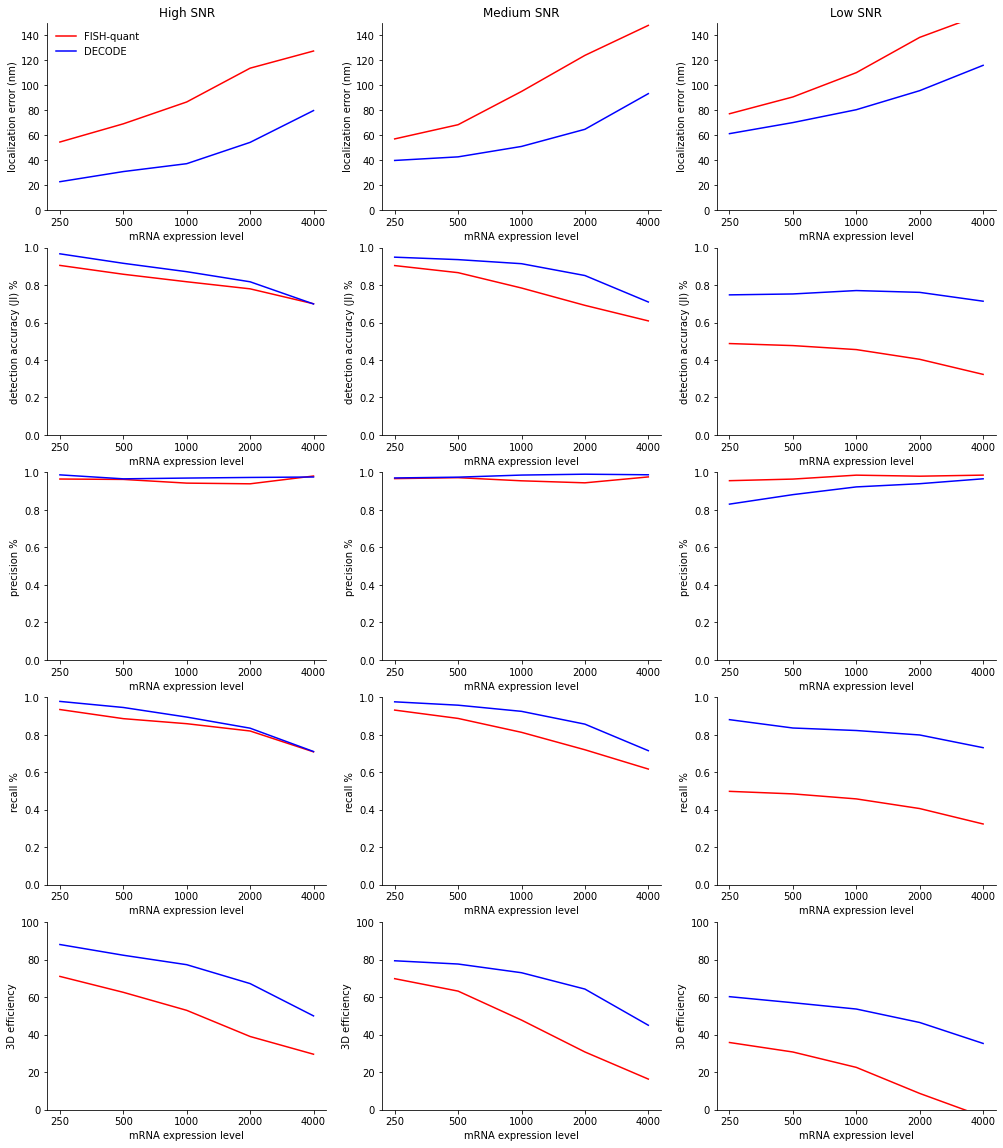

In [153]:
metrics = ['rmse_vol','jaccard','precision','recall','eff_3d']
algs = ['FISH-quant','DECODE']
alg_cols = {'FISH-quant':'red','DECODE':'blue'}
metric_lims = {'rmse_vol':[0,150],'jaccard':[0,1],'recall':[0,1],'precision':[0,1],'eff_3d':[0,100]}

plt.figure(figsize=(17,20))

for i,m in enumerate(metrics):
    for j,snr in enumerate(snrs):
        plt.subplot(len(metrics),3,j + i*3 + 1)

        for a in algs:
            if snr in total_dict[a]:
                plt.plot(np.arange(len(densities)), [d[m] for d in total_dict[a][snr]], label=a, color=alg_cols[a], linestyle='-')

        if i == 0 and j == 0:
            plt.legend(frameon=False)
        plt.ylabel(axis_names[m])
        plt.xlabel('mRNA expression level')
        plt.xticks(ticks=np.arange(len(densities)),labels=densities)
        plt.ylim(metric_lims[m])
        if i==0:
            plt.title(snr)
        sns.despine()

In [360]:
filename = 'g1_file'
with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    print(f['eval_densities']['500'].keys())
    runs = list(f['eval_densities']['500'].keys())
    del(runs[0])
    del(runs[0])
colors = sns.color_palette(n_colors=len(runs)+1)

<KeysViewHDF5 ['FQ', 'GT', 'start_psf:3000', 'start_psf:30000', 'start_psf:30001']>


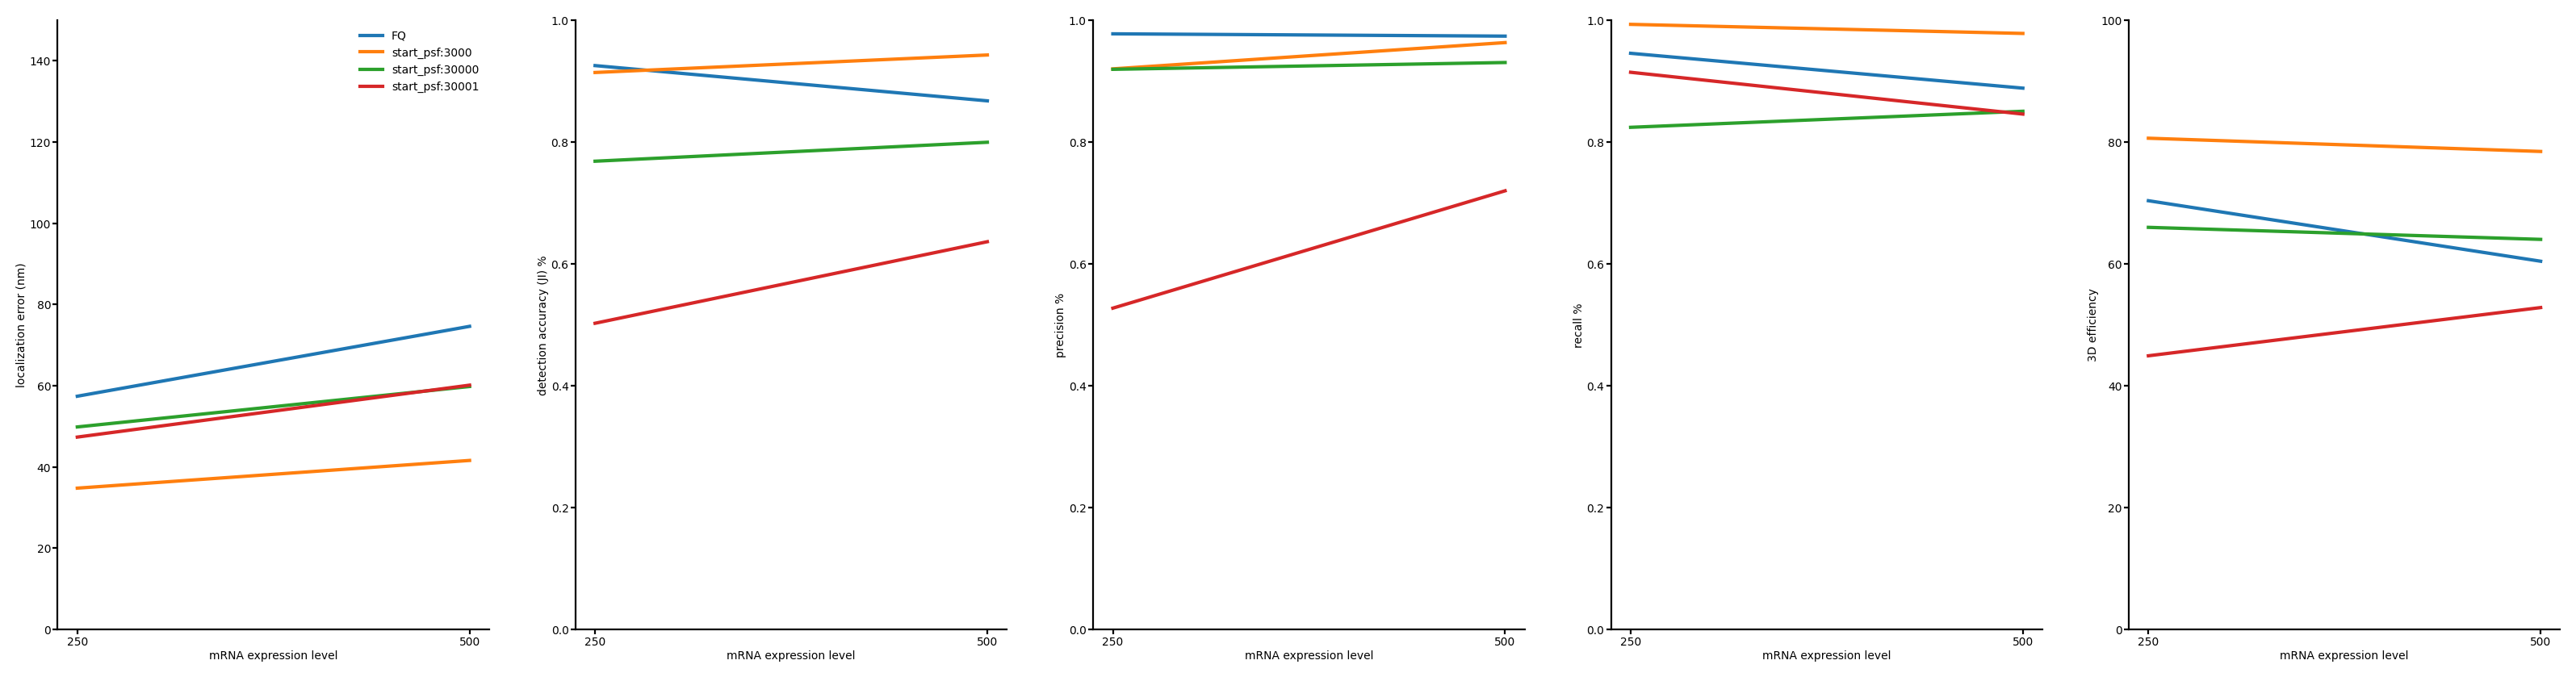

In [361]:
metrics = ['rmse_vol','jaccard','precision','recall','eff_3d']
alg_names = {'FISH-quant':'FQ'}
alg_cols = {'FISH-quant':colors[0]}
for i,r in enumerate(runs):
    alg_names[f'DECODE{i}'] = r
    alg_cols[f'DECODE{i}'] = colors[i+1]

metric_lims = {'rmse_vol':[0,150],'jaccard':[0,1],'recall':[0,1],'precision':[0,1],'eff_3d':[0,100]}
densities = [250,500]

plt.figure(figsize=(20,5))

with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:

    for i,m in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        
        for n,k in alg_names.items():
            plt.plot(np.arange(len(densities)), [f['eval_densities'][str(d)][k]['performance'][m][()][0] for d in densities], label=alg_names[n], color=alg_cols[n], linestyle='-')

        if i == 0:
            plt.legend(frameon=False)
        plt.ylabel(axis_names[m])
        plt.xlabel('mRNA expression level')
        plt.xticks(ticks=np.arange(len(densities)),labels=densities)
        plt.ylim(metric_lims[m])

        sns.despine()

(0.0, 40.0)

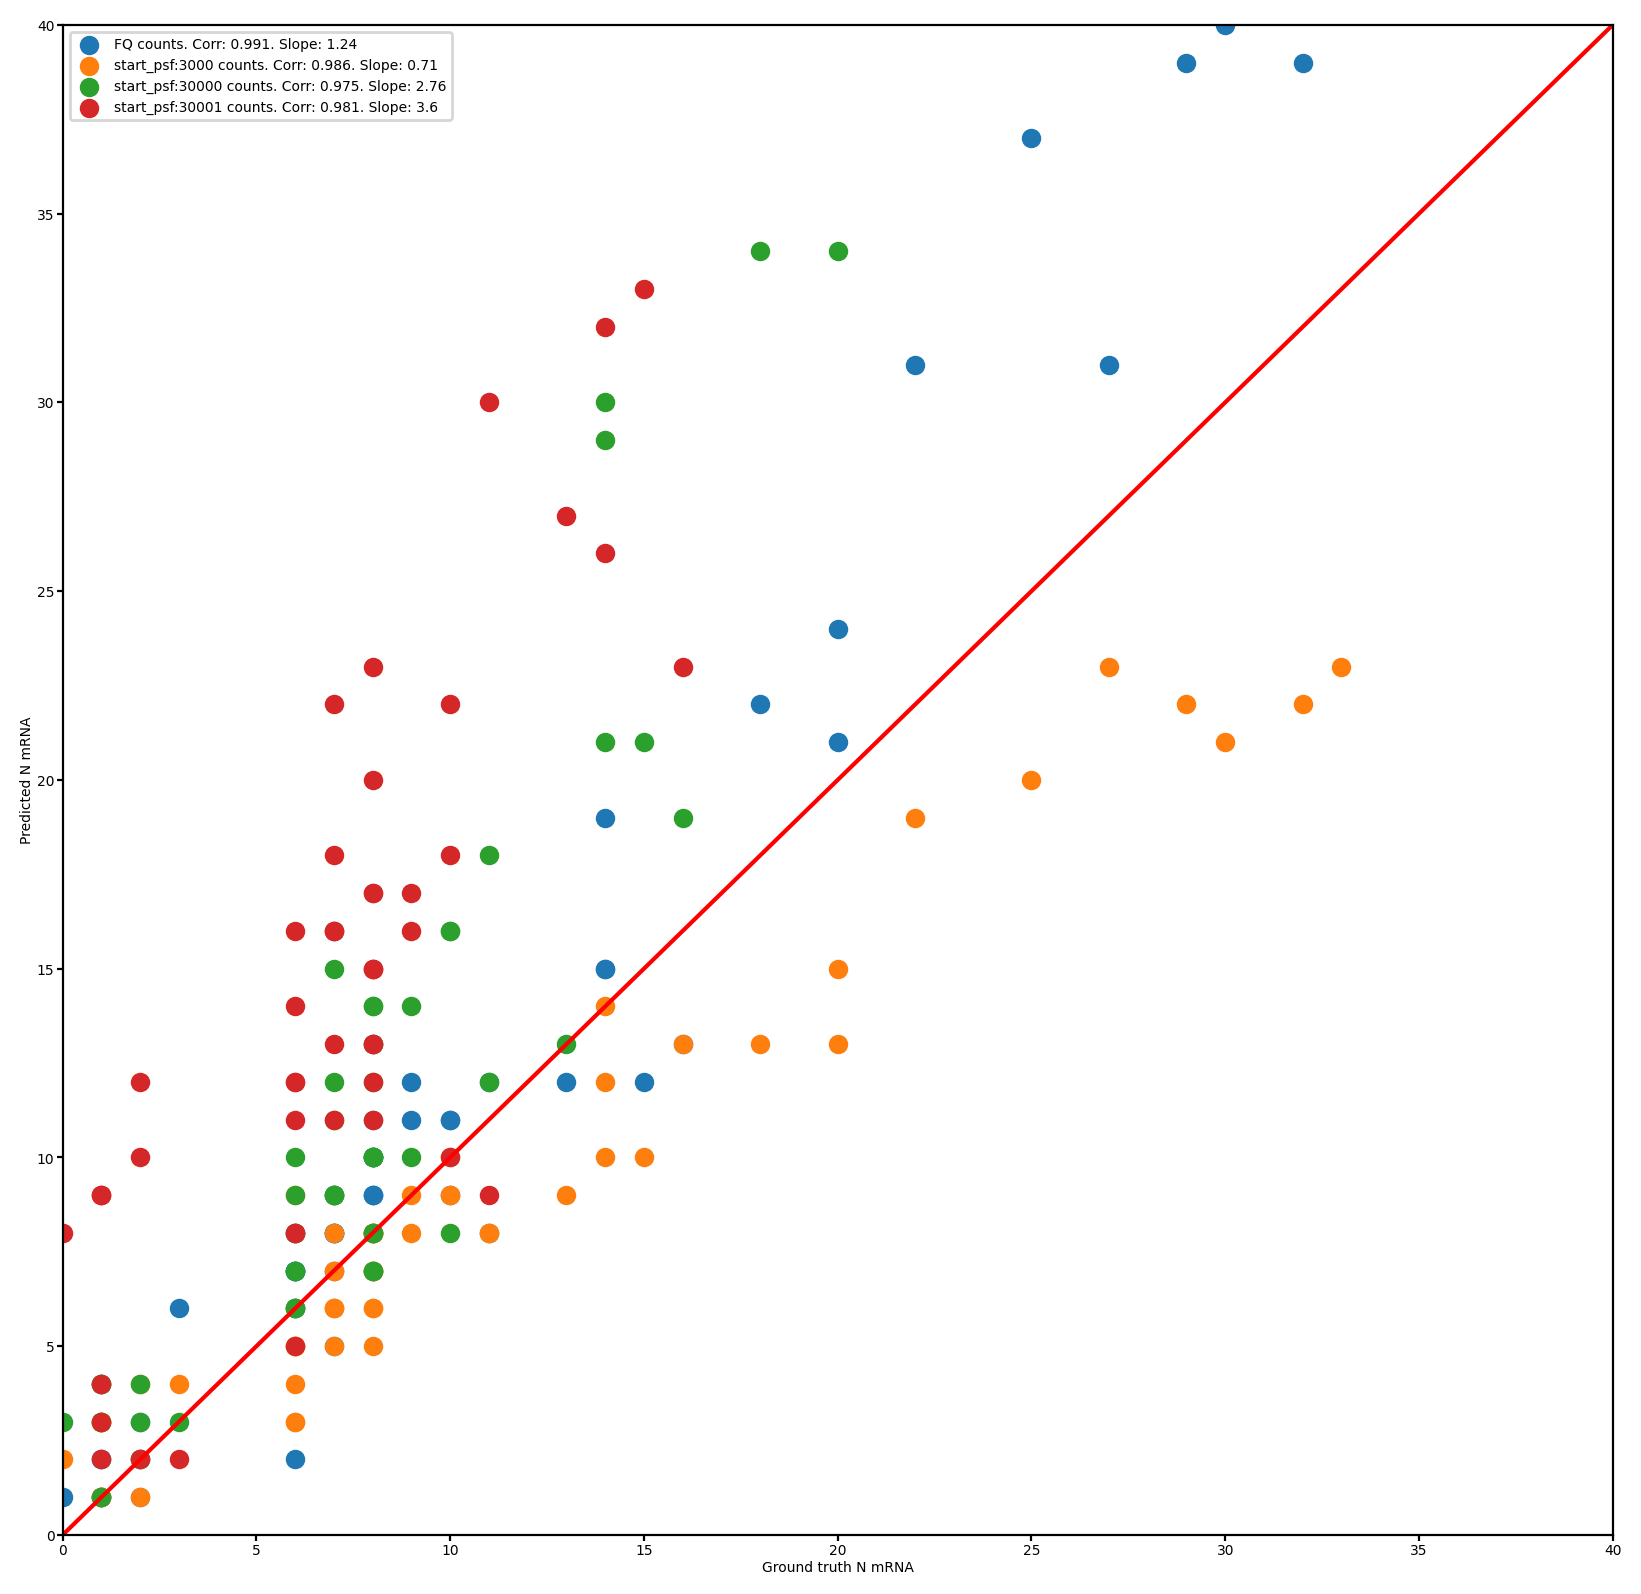

In [362]:
plt.figure(figsize=(10,10))

with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    
    GT = f['eval_foci']['GT']['foci_counts'][()]
    
    for i,a in enumerate(f['eval_foci'].keys()):
        if a != 'GT':
            pred_count = f['eval_foci'][a]['foci_counts'][()]
            corr = np.round(np.corrcoef([GT, pred_count])[0,1],3)
            slope = np.round(np.linalg.lstsq(GT.reshape(-1,1), pred_count,rcond=None)[0][0],2)
            plt.scatter(GT, pred_count, label=f'{a} counts. Corr: {corr}. Slope: {slope}', alpha=1.0)
            
plt.legend()
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.xlim(0,40)
plt.ylim(0,40)


(0.0, 40.0)

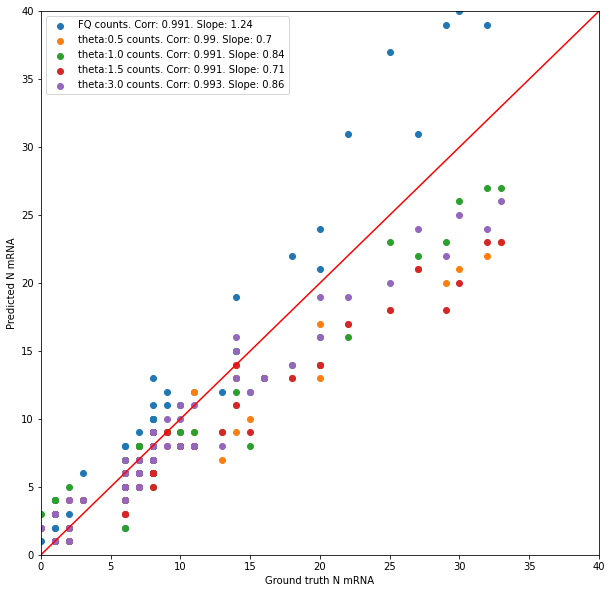

In [75]:
plt.figure(figsize=(10,10))

with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    
    GT = f['eval_foci']['GT']['foci_counts'][()]
    
    for i,a in enumerate(f['eval_foci'].keys()):
        if a != 'GT':
            pred_count = f['eval_foci'][a]['foci_counts'][()]
            corr = np.round(np.corrcoef([GT, pred_count])[0,1],3)
            slope = np.round(np.linalg.lstsq(GT.reshape(-1,1), pred_count,rcond=None)[0][0],2)
            plt.scatter(GT, pred_count, label=f'{a} counts. Corr: {corr}. Slope: {slope}', alpha=1.0)
            
plt.legend()
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.xlim(0,40)
plt.ylim(0,40)


KeyError: "Unable to open object (object 'conc_pre' doesn't exist)"

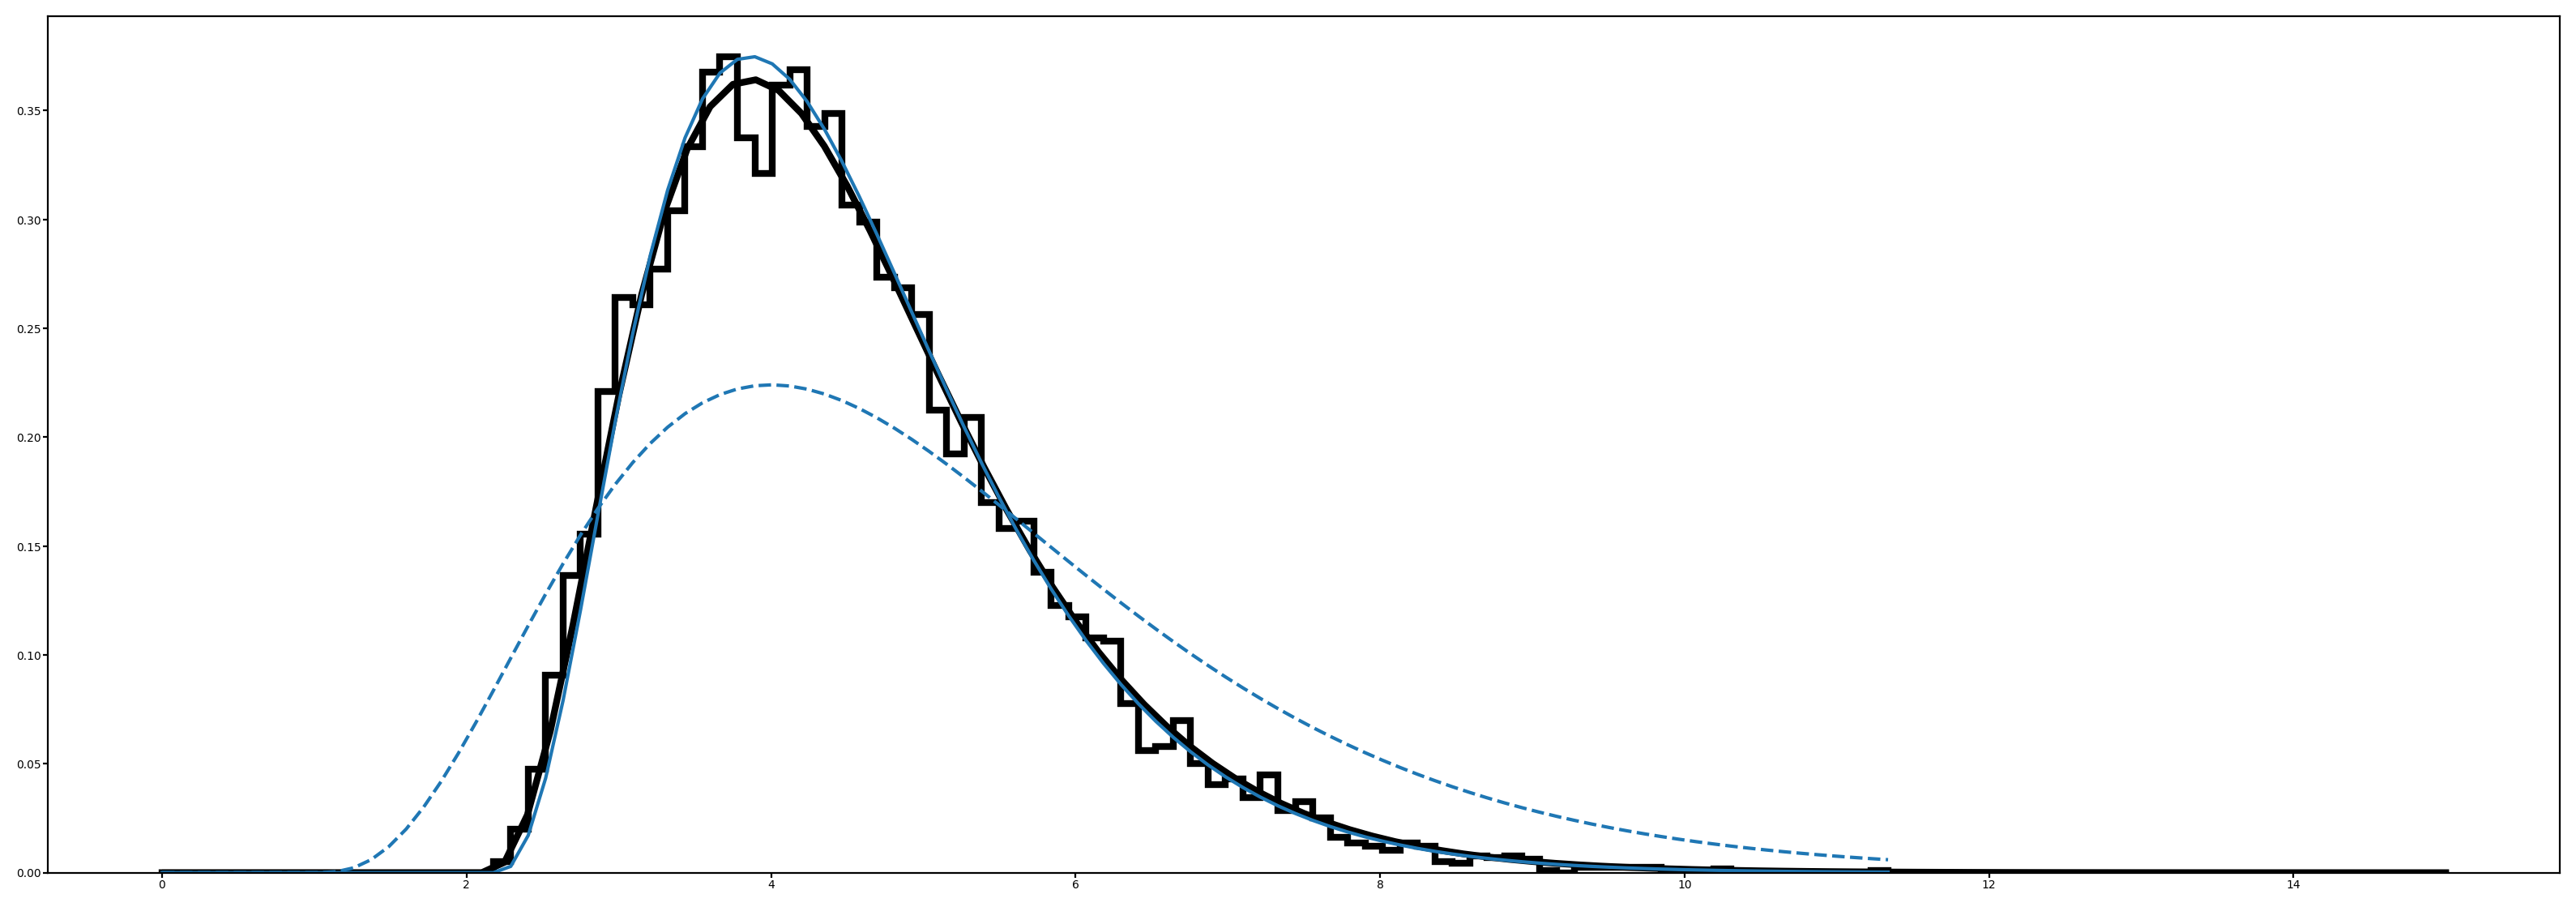

In [363]:
import scipy.stats as stats  

plt.figure(figsize=(20,7))

basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
full_gt_df = DF()
for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 2000, 'random', 'NR', i)
    full_gt_df = cat_emitter_dfs([full_gt_df, gt_df])

gt_ints = full_gt_df['int']
int_max = gt_ints.max()
bins = np.linspace(0, int_max, 100)

shape = 3.7504156297802815, 
scale = 0.6406917808418713, 
locaction = 2.104038290757017


x = np.linspace(0,15,101)
y = stats.gamma.pdf(x, shape, locaction, scale)
plt.plot(x, y, label='Fit', linewidth=3, color='black')

_ = plt.hist(gt_ints, bins=bins, label='GT', color='black', linewidth=3, histtype='step', density=True)

with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    
    colors = sns.color_palette(n_colors=len(f['microscope_state'].keys()))
    
    for i,m in enumerate(f['microscope_state'].keys()):
        
        g = f['microscope_state'][m]
        y_pre = stats.gamma.pdf(bins, g['conc_pre'][()], g['loc_pre'][()], 1/g['rate_pre'][()])
        plt.plot(bins, y_pre, linestyle='--', c=colors[i])
        
        y_post = stats.gamma.pdf(bins, g['conc_post'][()], g['loc_post'][()], 1/g['rate_post'][()])
        plt.plot(bins, y_post, label=m, c=colors[i])
        
#         plt.hist(f['eval_densities']['2000'][m]['locations']['int']+g['loc_post'][()], density=True, bins=bins, color=colors[i], alpha=0.2)
        
plt.legend()

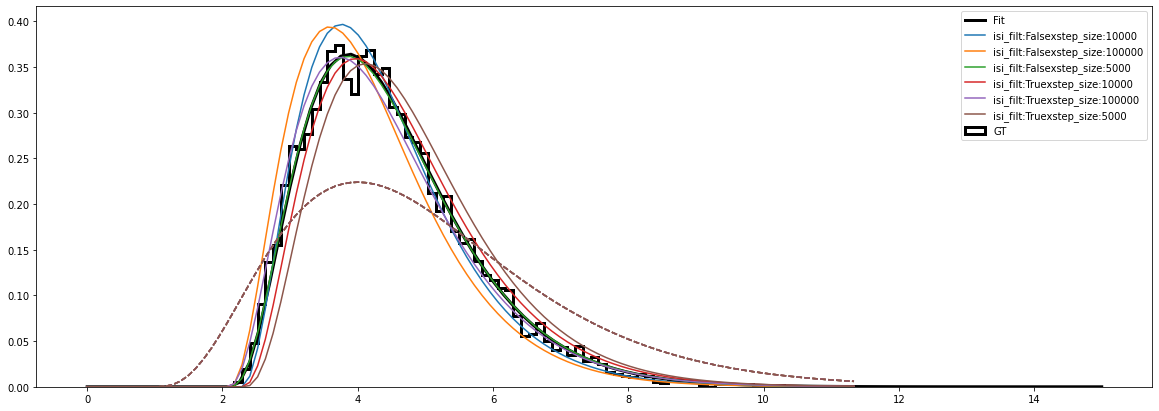

In [80]:
import scipy.stats as stats  

plt.figure(figsize=(20,7))

basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
full_gt_df = DF()
for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 2000, 'random', 'NR', i)
    full_gt_df = cat_emitter_dfs([full_gt_df, gt_df])

gt_ints = full_gt_df['int']
int_max = gt_ints.max()
bins = np.linspace(0, int_max, 100)

shape = 3.7504156297802815, 
scale = 0.6406917808418713, 
locaction = 2.104038290757017


x = np.linspace(0,15,101)
y = stats.gamma.pdf(x, shape, locaction, scale)
plt.plot(x, y, label='Fit', linewidth=3, color='black')

_ = plt.hist(gt_ints, bins=bins, label='GT', color='black', linewidth=3, histtype='step', density=True)

with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    
    colors = sns.color_palette(n_colors=len(f['microscope_state'].keys()))
    
    for i,m in enumerate(f['microscope_state'].keys()):
        
        g = f['microscope_state'][m]
        y_pre = stats.gamma.pdf(bins, g['conc_pre'][()], g['loc_pre'][()], 1/g['rate_pre'][()])
        plt.plot(bins, y_pre, linestyle='--', c=colors[i])
        
        y_post = stats.gamma.pdf(bins, g['conc_post'][()], g['loc_post'][()], 1/g['rate_post'][()])
        plt.plot(bins, y_post, label=m, c=colors[i])
        
#         plt.hist(f['eval_densities']['2000'][m]['locations']['int']+g['loc_post'][()], density=True, bins=bins, color=colors[i], alpha=0.2)
        
plt.legend()

In [312]:
filename = 'g1_file'
with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    
    GT = f['psf_state']['gt_psf'][()]
    GT /= GT.max()
    plot_3d_projections(GT)
    for m in f['psf_state'].keys():
        if 'gt' not in m:
            fit = f['psf_state'][m]['fit_psf'][()]
            fit /= fit.max()
            plot_3d_projections(fit)
        
        

KeyError: "Unable to open object (object 'psf_state' doesn't exist)"

In [364]:
import matplotlib
import matplotlib.gridspec as gridspec
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['font.size'] = '5'
matplotlib.rcParams['axes.labelpad'] = 1
matplotlib.rcParams['xtick.major.pad'] = 1
matplotlib.rcParams['xtick.minor.pad'] = 1
matplotlib.rcParams['ytick.major.pad'] = 1
matplotlib.rcParams['ytick.minor.pad'] = 1

matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.minor.size'] = 1.5
matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.minor.size'] = 1.5

In [365]:
import scipy.stats as stats  
filename = 'g1_file'
with h5py.File(f'../data/results/{filename}.hdf5', 'r') as f:
    print(f['eval_densities']['500'].keys())
    runs = list(f['eval_densities']['500'].keys())[:4]
    del(runs[0])
    del(runs[0])
colors = sns.color_palette(n_colors=len(runs)+1)

alg_names = {'FQ':'FISH-quant', 'start_psf:3000':'DECODE learned PSF', 'start_psf:30000':'DECODE fixed PSF'}
alg_cols = {'FQ':colors[0]}

for i,r in enumerate(runs):
#     alg_names[f'DECODE{i}'] = r
    if 'FQ' not in r:
        alg_cols[r] = colors[i+1]

metric_lims = {'rmse_vol':[0,150],'jaccard':[0,1],'recall':[0,1],'precision':[0,1],'eff_3d':[0,100]}
densities = [250,500,1000,2000]


basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
full_gt_df = DF()

for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 2000, 'random', 'NR', i)
    full_gt_df = cat_emitter_dfs([full_gt_df, gt_df])
    
gt_imgs = []
sl = np.s_[:1,:,50:150,50:150]
for d in densities:
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, d, 'random', 'NR', 0)
    gt_imgs.append(cpu(img)[0][sl[1:]])

gt_ints = full_gt_df['int']
int_max = gt_ints.max()
bins = np.linspace(0, int_max, 50)

<KeysViewHDF5 ['FQ', 'GT', 'start_psf:3000', 'start_psf:30000', 'start_psf:30001']>


/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


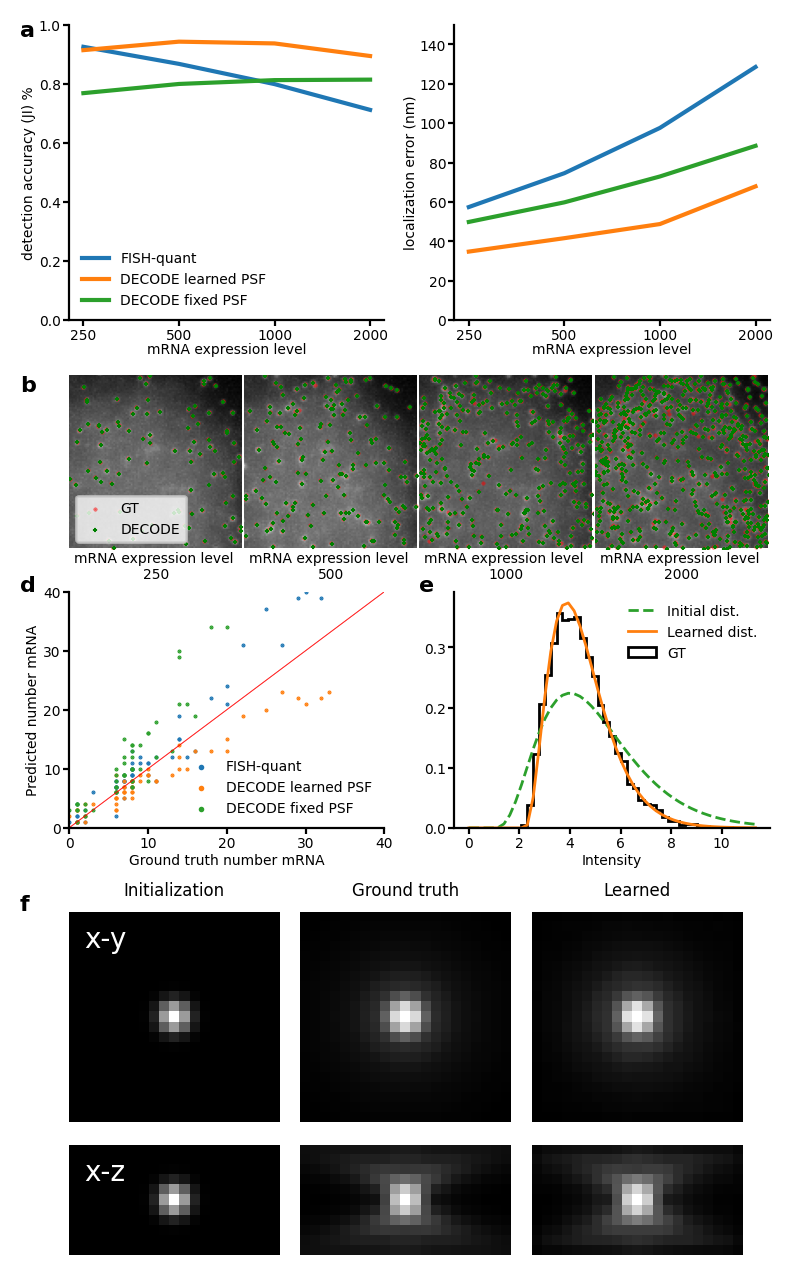

In [366]:
plt.rcParams['figure.dpi'] = 200
fig = plt.figure(figsize=cm2inch(8.9,15), constrained_layout=True)
tot_figure = fig.add_axes([0.0, 0.0, 1.0, 1.0])
tot_figure.axis('off')

x1 = 0.
x2 = 0.55


y1 = 0.75
y2 = 0.53
y3 = 0.32

h1 = 0.25
h2 = 0.2
h3 = 0.248

w1 = 0.45
w2 = 0.248

y4 = 0.07
y5 = 0.0
x31=0.3
x32=0.65
w3 = 0.3

ax_a = [fig.add_axes([x1,y1,w1,h1]), fig.add_axes([x2,y1,w1,h1])]  

with h5py.File(f'../data/results/{filename}.hdf5', 'a') as f:
    
    metrics = ['jaccard', 'rmse_vol']

    density_label = 'mRNA expression level'
    
    for i,m in enumerate(metrics):     
        for k,n in alg_names.items():
            ax_a[i].plot(np.arange(len(densities)), [f['eval_densities'][str(d)][k]['performance'][m][()][0] for d in densities], label=n, color=alg_cols[k], linestyle='-')

        ax_a[i].set_ylabel(axis_names[m])
        ax_a[i].set_xlabel(density_label,labelpad=0)
        ax_a[i].set_xticks(np.arange(len(densities)))
        ax_a[i].set_xticklabels(labels=densities)
        ax_a[i].set_ylim(metric_lims[m])

        if not i:
            ax_a[i].legend(frameon=False)
            
ax_b = [fig.add_axes([0.0,y2,w2,h2]), fig.add_axes([0.25,y2,w2,h2]), fig.add_axes([0.5,y2,w2,h2]), fig.add_axes([0.75,y2,w2,h2])]
    
with h5py.File(f'../data/results/{filename}.hdf5', 'a') as f:
    for i,d in enumerate(densities):

        gt_f = crop_df(get_df_from_hdf5(f['eval_densities'][str(d)]['GT']['locations']), sl, px_size_zyx=[100., 100., 100.])
        pred = crop_df(get_df_from_hdf5(f['eval_densities'][str(d)]['start_psf:3000']['locations']), sl, px_size_zyx=[100., 100., 100.])

        ax_b[i].imshow(gt_imgs[i].max(0), cmap='gray')
        ax_b[i].scatter(gt_f['x']/100,gt_f['y']/100, s=0.3, color='red', alpha=0.5, marker='*', label='GT')
        ax_b[i].scatter(pred['x']/100+0.5,pred['y']/100+0.5, s=0.5, color='green', alpha=1., marker='+', label='DECODE')
        ax_b[i].text(50,117,f'mRNA expression level \n{d}',ha='center')
        ax_b[i].axis('off')    
        
        ax_b[i].set_xlim(0,100)
        ax_b[i].set_ylim(100,0)
    ax_b[0].legend(frameon=True)
            
ax_c = fig.add_axes([x1,y3,w1,h2])

with h5py.File(f'../data/results/{filename}.hdf5', 'a') as f:
    
    GT = f['eval_foci']['GT']['foci_counts'][()]
    
    for k,n in alg_names.items():
        if a != 'GT':
            pred_count = f['eval_foci'][k]['foci_counts'][()]
            corr = np.round(np.corrcoef([GT, pred_count])[0,1],3)
            slope = np.round(np.linalg.lstsq(GT.reshape(-1,1), pred_count,rcond=None)[0][0],2)
            ax_c.scatter(GT, pred_count, alpha=1., s=0.2, color=alg_cols[k]) # \n Corr: {corr}. Slope: {slope}
            ax_c.scatter([-5,-5],[-5,-5],color=alg_cols[k], label=f'{n}', alpha=1.0, s=1.) # \n Corr: {corr}. Slope: {slope}
            ax_c.plot([0,40],[0,40],color='red', linewidth=0.3, alpha=0.5)
    
    plt.locator_params(axis = 'x', nbins = 4)
    plt.locator_params(axis = 'y', nbins = 4)
    
    ax_c.legend(frameon=False)
    
    ax_c.set_xlim(0,40)
    ax_c.set_ylim(0,40)
    
    ax_c.set_xlabel('Ground truth number mRNA')
    ax_c.set_ylabel('Predicted number mRNA')

ax_d = fig.add_axes([x2,y3,w1,h2])

with h5py.File(f'../data/results/{filename}.hdf5', 'a') as f:
    
    _ = ax_d.hist(gt_ints, bins=bins, label='GT', color='black', linewidth=1, histtype='step', density=True)
    
    for k,n in alg_names.items():
        if 'learned' in n:
        
            g = f['microscope_state'][k]
            y_pre = stats.gamma.pdf(bins, g['conc_pre'][()], g['loc_pre'][()], 1/g['rate_pre'][()])
            plt.plot(bins, y_pre, linestyle='--', c=colors[-1], linewidth=1, label='Initial dist.')
        
            y_post = stats.gamma.pdf(bins, g['conc_post'][()], g['loc_post'][()], 1/g['rate_post'][()])
            plt.plot(bins, y_post, c=alg_cols[k], linewidth=1, label='Learned dist.')    
    
    plt.locator_params(axis = 'y', nbins = 4)
    ax_d.legend(frameon=False)
    ax_d.set_xlabel('Intensity')
    
y4 = 0.05
y5 = -0.05
x31=0.33
x32=0.66
w3 = 0.3
h4=0.22
h5=0.22/2

ax_e = [fig.add_axes([x1,y4,w3,h4]), fig.add_axes([x1,y5,w3,h5]),
        fig.add_axes([x31,y4,w3,h4]), fig.add_axes([x31,y5,w3,h5]),
        fig.add_axes([x32,y4,w3,h4]), fig.add_axes([x32,y5,w3,h5])]  

with h5py.File(f'../data/results/{filename}.hdf5', 'a') as f:
    
#     psf_gt = f['psf_state']['gt_psf'][()]
#     psf_fit = f['psf_state'][list(alg_names.keys())[1]]['fit_psf'][()]
#     psf_init = f['psf_state'][list(alg_names.keys())[1]]['init_psf'][()]
    
    psf_gt /= psf_gt.max()
    psf_fit /= psf_fit.max()
    psf_init /= psf_init.max()

    ax_e[0].imshow(psf_init.mean(0), cmap='gray')
    ax_e[0].text(1,3,'x-y', color='white', fontsize=10)
    ax_e[0].set_title('Initialization')
    
    ax_e[1].imshow(psf_init.mean(1), cmap='gray')
    ax_e[1].text(1,3,'x-z', color='white', fontsize=10)
    
    ax_e[2].imshow(psf_gt.mean(0), cmap='gray')
    ax_e[2].set_title('Ground truth')
    ax_e[3].imshow(psf_gt.mean(1), cmap='gray')
    
    ax_e[4].imshow(psf_fit.mean(0), cmap='gray')
    ax_e[4].set_title('Learned')
    ax_e[5].imshow(psf_fit.mean(1), cmap='gray')
    
    for a in ax_e:
        a.axis('off')
        
tot_figure.text(-0.07, 0.99, 'a', fontsize=8, ha='left', fontweight='bold')
tot_figure.text(-0.07, 0.69, 'b', fontsize=8, ha='left', fontweight='bold')
tot_figure.text(-0.07, 0.52, 'd', fontsize=8, ha='left', fontweight='bold')
tot_figure.text(0.5, 0.52, 'e', fontsize=8, ha='left', fontweight='bold')
tot_figure.text(-0.07, 0.25, 'f', fontsize=8, ha='left', fontweight='bold')
    
sns.despine()

In [322]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_g1/start_psf:3000/train.yaml')

cfg.foci.n_foci_avg = 0.0
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)

psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])
psf_init /= psf_init.max()
psf_vol /= psf_vol.max()
psf_fit = psf_vol

20 volumes


In [315]:
psf_gt = cpu(load_tiff_image(cfg.evaluation.psf_path)[0])
psf_gt /= psf_gt.max()